<h1 style="font-size:3em; text-align: center">Forecasting With Facebook's Open Source Prophet</h1>

In [122]:
# imports
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import math
from sklearn.metrics       import mean_squared_error
# jupyter command - allows plots to show up
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

np.random.seed(69)

## Imports the Same Dataset as the LSTM Model

In [123]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5000)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['y'] = dataframe.sum(axis=1)
dataframe['ds'] = dataframe.index.round(time_grouping)


# The data set with the sum of all the cars out at the 
dataframe = dataframe[['y','ds']].groupby('ds').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

## Manipulates the Data To Better Fit Prophet's Expectations

In [124]:
dataframe = dataframe.reset_index()
dataframe['y'] = np.log(dataframe['y'])
dataframe.head()

,ds,y
0,2016-01-01 00:00:00,5.934894
1,2016-01-01 00:05:00,7.065613
2,2016-01-01 00:10:00,7.329094
3,2016-01-01 00:15:00,7.261225
4,2016-01-01 00:20:00,7.208600


## We Create and Fit the Model

Prophet was designed to be fit once, so unlike the LSTM Neural Network, Prophet's accuracy depends on the magnitude of data, not the number of times fit. This avoids any risk of over-fitting, but would not be effective if we don't have several days of data. 

In [125]:
model = Prophet(daily_seasonality=True, yearly_seasonality=False)
model.fit(dataframe)

## The Model Then Generates an Empty Dataframe with a column of Datetime values

In [126]:
future = model.make_future_dataframe(periods=1, freq=time_grouping)
future.head()

,ds
0,2016-01-01 00:00:00
1,2016-01-01 00:05:00
2,2016-01-01 00:10:00
3,2016-01-01 00:15:00
4,2016-01-01 00:20:00


## The Model is Then Given the Empty Dataframe, Which It Will Fill With Forecasted Data

In [127]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2016-01-01 00:00:00,6.684631,6.314828,7.060124
1,2016-01-01 00:05:00,6.655187,6.293501,7.033533
2,2016-01-01 00:10:00,6.625400,6.243792,6.996025
3,2016-01-01 00:15:00,6.595151,6.220164,6.959772
4,2016-01-01 00:20:00,6.564321,6.207312,6.915739


## Here we Invert the np.log transformation to get the true values

In [128]:
# undoes the np.log transformation done earlier
forecast['yhat_upper'] = np.exp(forecast['yhat_upper'])
forecast['yhat'] = np.exp(forecast['yhat'])
forecast['yhat_lower'] = np.exp(forecast['yhat_lower'])
dataframe['y'] = np.exp(dataframe["y"])

## Now We Graph the Forecasted Data ontop of the True Data to Evaluate The Error

### day

This is the first day to be graphed (inclusive).

### total_days

This is the total number of days to be graphed after and including the first day.


294.52 RMSE


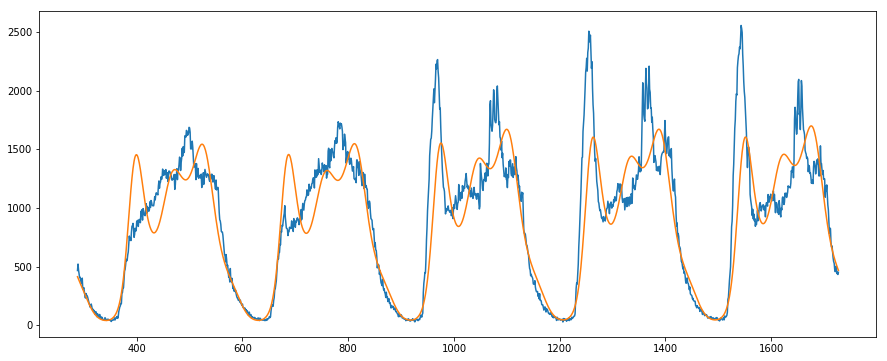

In [129]:
day = 1

total_days = 5

# plots the actual data
plt.plot(dataframe['y'][288*day:288*total_days + 288*day])
# plots Prophet's forecasted data
#plt.plot(forecast['yhat_upper'][288*day:288*total_days + 288*day])
plt.plot(forecast['yhat'      ][288*day:288*total_days + 288*day])
#plt.plot(forecast['yhat_lower'][288*day:288*total_days + 288*day])

rmse = math.sqrt(mean_squared_error(dataframe['y'][288*day:288*total_days + 288*day], forecast['yhat'][288*day:288*total_days + 288*day]))
print "%.2f RMSE" % (rmse)